In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dense, ZeroPadding2D, Activation,Dropout
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
from os import *
warnings.filterwarnings('ignore')

In [3]:
x = []
y = []
for directory in ['/content/drive/MyDrive/augmented data/yes', '/content/drive/MyDrive/augmented data/no']:
    for filename in listdir(directory):
        image = cv2.imread(directory + '/' + filename)
        image = cv2.resize(image, dsize=(240,240), interpolation=cv2.INTER_CUBIC)
        image = image / 255.
        x.append(image)
        if directory[-3:] == 'yes':
            y.append([1])
        else:
            y.append([0])

In [14]:
# import pandas as pd
# data = pd.read_csv('/content/drive/MyDrive/augmented data')

In [4]:
x = np.array(x)
y = np.array(y)
x, y = shuffle(x, y)

print(f'Number of samples : {len(x)}')
print(f'x shape : {x.shape}')
print(f'y shape : {y.shape}')

Number of samples : 2040
x shape : (2040, 240, 240, 3)
y shape : (2040, 1)


In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15, random_state=101)

In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('BrainTumorModelv3_3colab.h5', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [7]:
input = Input((240, 240, 3))
model = ZeroPadding2D((2, 2))(input)
# model = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(model)
# model = MaxPooling2D((4, 4), name='max_pool0')(model)
model = BatchNormalization(axis=3, name='bn0')(model)
model = Activation('relu')(model)
# model = Conv2D(64, (7, 7), strides=(1, 1), name='conv1')(model)
# model = MaxPooling2D((4, 4), name='max_pool1')(model)

model = Conv2D(128, (7, 7), strides=(1, 1), name='conv2')(model)
model = MaxPooling2D((4, 4), name='max_pool2')(model)
model = Conv2D(64, (7, 7), strides=(1, 1), name='conv1')(model)
model = MaxPooling2D((4, 4), name='max_pool1')(model)
model = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(model)
model = MaxPooling2D((4, 4), name='max_pool0')(model)

# model = MaxPooling2D((4, 4), name='max_pool0')(model)
# model = MaxPooling2D((4, 4), name='max_pool1')(model)
model = Flatten()(model)
model = Dense(16, activation='relu')(model)
model = Dense(1, activation='sigmoid', name='fc')(model)
model = Model(inputs=input, outputs=model, name='BrainTumorDetection')
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
print(model.summary())

Model: "BrainTumorDetection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 bn0 (BatchNormalization)    (None, 244, 244, 3)       12        
                                                                 
 activation (Activation)     (None, 244, 244, 3)       0         
                                                                 
 conv2 (Conv2D)              (None, 238, 238, 128)     18944     
                                                                 
 max_pool2 (MaxPooling2D)    (None, 59, 59, 128)       0         
                                               

In [9]:
history = model.fit(x=xtrain, y=ytrain, batch_size=32, epochs=10,callbacks=[mcp_save,earlyStopping],validation_split=0.10)

Epoch 1/10
49/49 [==============================] - 604s 12s/step - loss: 0.9251 - accuracy: 0.6205 - val_loss: 0.5840 - val_accuracy: 0.6839
Epoch 2/10
49/49 [==============================] - 616s 13s/step - loss: 0.4932 - accuracy: 0.7705 - val_loss: 0.5487 - val_accuracy: 0.7184
Epoch 3/10
49/49 [==============================] - 608s 12s/step - loss: 0.3793 - accuracy: 0.8276 - val_loss: 0.4537 - val_accuracy: 0.7586
Epoch 4/10
49/49 [==============================] - 597s 12s/step - loss: 0.3512 - accuracy: 0.8551 - val_loss: 0.3993 - val_accuracy: 0.8218
Epoch 5/10
49/49 [==============================] - 600s 12s/step - loss: 0.2894 - accuracy: 0.8788 - val_loss: 0.4397 - val_accuracy: 0.7816
Epoch 6/10
49/49 [==============================] - 594s 12s/step - loss: 0.2524 - accuracy: 0.8910 - val_loss: 0.3929 - val_accuracy: 0.8046
Epoch 7/10
49/49 [==============================] - 596s 12s/step - loss: 0.2073 - accuracy: 0.9186 - val_loss: 0.3386 - val_accuracy: 0.8678
Epoch 

In [10]:
test_pred = np.round(model.predict(xtest))
train_pred = np.round(model.predict(xtrain))

55/55 [==============================] - 156s 3s/step


In [11]:
def thres(pred):
    output = []
    for i in pred:
        if i > 0.8:
            output.append([1])
        else:
            output.append([0])
    return output

test_output = thres(test_pred)
train_output = thres(train_pred)

In [12]:
print('Training Data Metrics')
print(confusion_matrix(ytrain, train_output))
print(accuracy_score(ytrain, train_output))
print('Testing Data Metrics')
print(confusion_matrix(ytest, test_output))
print(accuracy_score(ytest, test_output))

Training Data Metrics
[[779  54]
 [ 18 883]]
0.9584775086505191
Testing Data Metrics
[[129  18]
 [ 15 144]]
0.8921568627450981


In [ ]:
model.history

In [15]:
model.save('BrainTumorModelv3_4colab.h5')

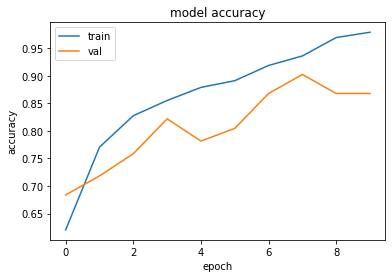

In [13]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

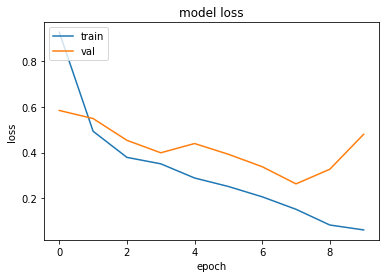

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import cv2
from keras.models import load_model
import numpy as np
model = load_model('BrainTumorModelv3_3colab.h5')
# photo = cv2.resize(cv2.imread('aug_Y1_0_4205.jpg'), dsize=(240,240), interpolation=cv2.INTER_CUBIC)

In [ ]:
pred = np.round(model.predict(np.array([photo / 255.]))[0][0])
if pred > 0.8:
    output = 'Brain Tumor Detected'
else:
    output = 'There is no Brain Tumor'


1/1 [==============================] - 0s 80ms/step


In [ ]:
output

'Brain Tumor Detected'